**Analysis of $NO_x$ Measurement near Highway**

We selected two stations and plotted their time series change in this document.
Station ID need to change for the station at Breukelen, please replace "NL10240" to "NL10641" for creating figures for the other station, also change caption name and file name accordingly.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import Grouper
from pandas import read_csv
pd.options.mode.chained_assignment = None  # default='warn'

In [65]:
# read RIVM NOx pollution data in the year 2019 and 2023, select the target station near Breda highway (NL10240) where there is a speed limit change in 2020.
NOx_2019=pd.read_csv("/Data/2019_NOx_breed.csv",sep=';',skiprows=5,encoding='unicode_escape')#read files
NOx_2023=pd.read_csv("/Data/2023_NOx_breed.csv",sep=';',skiprows=5,encoding='unicode_escape')#read files

# Select two stations near highway
selected_columns = [" begindatumtijd", "NL10240_NOx_lucht"]

# Create a new DataFrame with only the selected columns
NOx_2019_highway = NOx_2019[selected_columns]
NOx_2023_highway = NOx_2023[selected_columns]

In [67]:
# Convert the ' begindatumtijd' column in the format of %Y-%m-%dT%H:%M:%S in datetime, delete time zone info for further processing
NOx_2019_highway[' begindatumtijd'] = pd.to_datetime(NOx_2019_highway[' begindatumtijd'], format='%Y-%m-%dT%H:%M:%S%z')
NOx_2019_highway[' begindatumtijd'] = pd.to_datetime(NOx_2019_highway[' begindatumtijd']).dt.tz_localize(None)
NOx_2023_highway[' begindatumtijd'] = pd.to_datetime(NOx_2023_highway[' begindatumtijd'], format='%Y-%m-%dT%H:%M:%S%z')
NOx_2023_highway[' begindatumtijd'] = pd.to_datetime(NOx_2023_highway[' begindatumtijd']).dt.tz_localize(None)

In [69]:
# Combine datasets of two years together
# Extract the day and month as a common key (ignore the year)
NOx_2019_highway['day_month'] = NOx_2019_highway[' begindatumtijd'].dt.strftime('%m-%d')
NOx_2023_highway['day_month'] = NOx_2023_highway[' begindatumtijd'].dt.strftime('%m-%d')

# Merge the datasets on the 'day_month' key
combined_NOx = pd.merge(
    NOx_2019_highway,
    NOx_2023_highway,
    on='day_month',
    suffixes=('_2019', '_2023')
)

# Drop the 'day_month' column if it is no longer needed
combined_NOx.drop(columns=['day_month'], inplace=True)

In [71]:
# Select the period of October

# Ensure the column name has no leading/trailing spaces
combined_NOx.rename(columns=lambda x: x.strip(), inplace=True)

# Select rows where the month in 'begindatumtijd_2019' is October (10)
october_data = combined_NOx[combined_NOx['begindatumtijd_2019'].dt.month == 10]

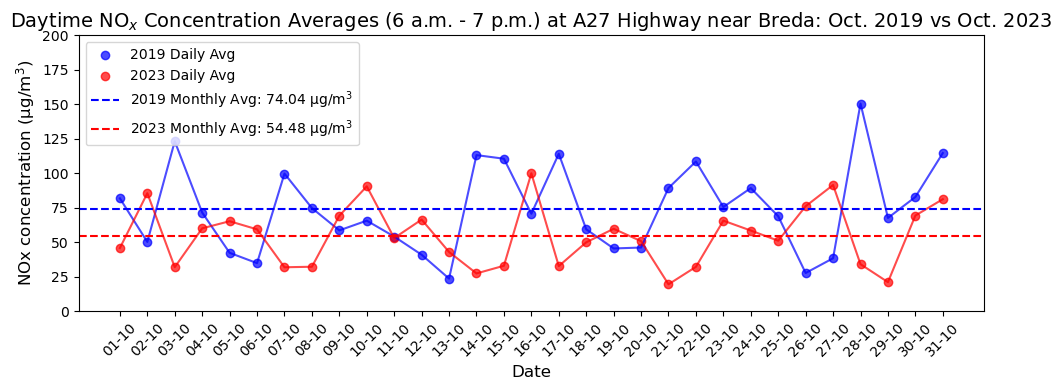

In [75]:
# For every day, select the period of 6 o'clock to 19 o'clock (day period), calculate the average for both years. 

# Filter rows for the day period (6:00 to 19:00) for both years
day_data = october_data[
    (october_data['begindatumtijd_2019'].dt.hour.between(6, 19)) &
    (october_data['begindatumtijd_2023'].dt.hour.between(6, 19))
]

# Extract the date part for both years
day_data['date'] =day_data['begindatumtijd_2019'].dt.date


# Group by date and calculate daily averages
daily_avg_d = day_data.groupby('date').agg(
    avg_NOx_2019=('NL10240_NOx_lucht_2019', 'mean'),
    avg_NOx_2023=('NL10240_NOx_lucht_2023', 'mean')
).reset_index()

# Format the date column to exclude the year and display as dd-mm
daily_avg_d['date'] = daily_avg_d['date'].apply(lambda x: x.strftime('%d-%m'))

# Calculate monthly averages
monthly_avg_d_2019 = daily_avg_d['avg_NOx_2019'].mean()
monthly_avg_d_2023 = daily_avg_d['avg_NOx_2023'].mean()

# Create the scatter plot
plt.figure(figsize=(10, 4))
plt.ylim(0, 200)  # Set the y-axis range
plt.scatter(daily_avg_d['date'], daily_avg_d['avg_NOx_2019'], color='blue', label='2019 Daily Avg', alpha=0.7)
plt.scatter(daily_avg_d['date'], daily_avg_d['avg_NOx_2023'], color='red', label='2023 Daily Avg', alpha=0.7)

# Connect the dots with solid lines for 2019
plt.plot(daily_avg_d['date'], daily_avg_d['avg_NOx_2019'], color='blue', linestyle='-', alpha=0.7)
plt.plot(daily_avg_d['date'], daily_avg_d['avg_NOx_2023'], color='red', linestyle='-', alpha=0.7)

# Add horizontal lines for monthly averages
plt.axhline(y=monthly_avg_d_2019, color='blue', linestyle='--', linewidth=1.5, label=f'2019 Monthly Avg: {monthly_avg_d_2019:.2f} µg/m$^3$')
plt.axhline(y=monthly_avg_d_2023, color='red', linestyle='--', linewidth=1.5, label=f'2023 Monthly Avg: {monthly_avg_d_2023:.2f} µg/m$^3$')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel(r'NOx concentration (µg/m$^3$)', fontsize=12)
plt.title('Daytime NO$_x$ Concentration Averages (6 a.m. - 7 p.m.) at A27 Highway near Breda: Oct. 2019 vs Oct. 2023', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend(loc=2)
plt.tight_layout()

# Save the figure
plt.savefig("/Users/zhiyuwu/Desktop/GRS-35306/GroupProject/Figures/DaytimeNOxBreda.png")

# Display the plot
plt.show()

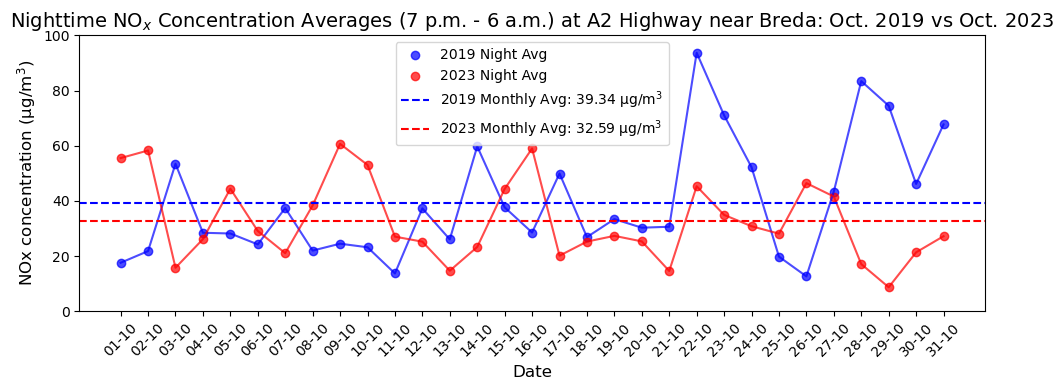

In [79]:
# For every day, select the period of 19 o'clock to 6 o'clock the next day (night period), calculate the average for both years. 

# Filter rows for the night period (19:00 to 6:00) for both years
night_data = october_data[
    ((october_data['begindatumtijd_2019'].dt.hour >= 19) | (october_data['begindatumtijd_2019'].dt.hour < 6)) &
    ((october_data['begindatumtijd_2023'].dt.hour >= 19) | (october_data['begindatumtijd_2023'].dt.hour < 6))
]

# Extract the date part for both years
night_data['date'] = night_data['begindatumtijd_2019'].dt.date

# Group by date and calculate daily averages
daily_avg_n = night_data.groupby('date').agg(
    avg_NOx_2019=('NL10240_NOx_lucht_2019', 'mean'),
    avg_NOx_2023=('NL10240_NOx_lucht_2023', 'mean')
).reset_index()

# Format the date column to exclude the year and display as dd-mm
daily_avg_n['date'] = daily_avg_n['date'].apply(lambda x: x.strftime('%d-%m'))

# Calculate monthly averages
monthly_avg_n_2019 = daily_avg_n['avg_NOx_2019'].mean()
monthly_avg_n_2023 = daily_avg_n['avg_NOx_2023'].mean()

# Create the scatter plot
plt.figure(figsize=(10, 4))
plt.ylim(0, 100)  # Set the y-axis range

plt.scatter(daily_avg_n['date'], daily_avg_n['avg_NOx_2019'], color='blue', label='2019 Night Avg', alpha=0.7)
plt.scatter(daily_avg_n['date'], daily_avg_n['avg_NOx_2023'], color='red', label='2023 Night Avg', alpha=0.7)

# Connect the dots with solid lines for 2019
plt.plot(daily_avg_n['date'], daily_avg_n['avg_NOx_2019'], color='blue', linestyle='-', alpha=0.7)
plt.plot(daily_avg_n['date'], daily_avg_n['avg_NOx_2023'], color='red', linestyle='-', alpha=0.7)

# Add horizontal lines for monthly averages
plt.axhline(y=monthly_avg_n_2019, color='blue', linestyle='--', linewidth=1.5, label=f'2019 Monthly Avg: {monthly_avg_n_2019:.2f} µg/m$^3$')
plt.axhline(y=monthly_avg_n_2023, color='red', linestyle='--', linewidth=1.5, label=f'2023 Monthly Avg: {monthly_avg_n_2023:.2f} µg/m$^3$')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel(r'NOx concentration (µg/m$^3$)', fontsize=12)
plt.title('Nighttime NO$_x$ Concentration Averages (7 p.m. - 6 a.m.) at A2 Highway near Breda: Oct. 2019 vs Oct. 2023', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("/Users/zhiyuwu/Desktop/GRS-35306/GroupProject/Figures/NighttimeNOxBreda.png")

# Display the plot
plt.show()

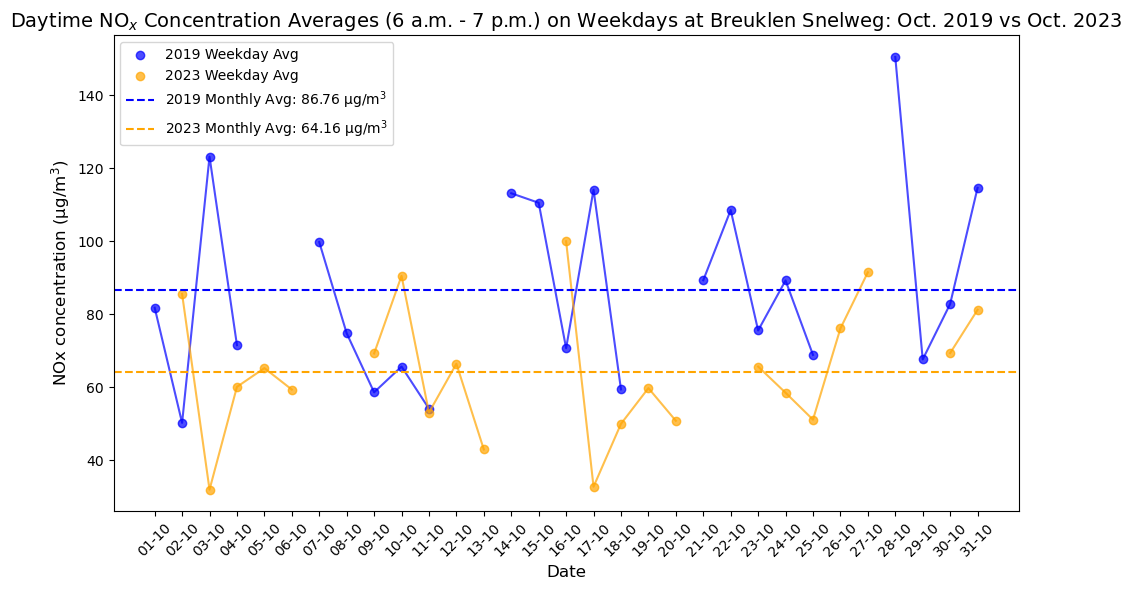

In [20]:
# Compare with weekdays and weekends (day period)

# Filter rows for weekdays in 2019 (Monday to Friday)
day_data_weekdays_2019 = day_data[day_data['begindatumtijd_2019'].dt.weekday < 5]

# Filter rows for weekdays in 2023 (Monday to Friday)
day_data_weekdays_2023 = day_data[day_data['begindatumtijd_2023'].dt.weekday < 5]

# Group by date and calculate daily averages for weekdays in 2019
daily_avg_d_weekdays_2019 = day_data_weekdays_2019.groupby('date').agg(
    avg_NOx_2019=('NL10240_NOx_lucht_2019', 'mean')
).reset_index()

# Group by date and calculate daily averages for weekdays in 2023
daily_avg_d_weekdays_2023 = day_data_weekdays_2023.groupby('date').agg(
    avg_NOx_2023=('NL10240_NOx_lucht_2023', 'mean')
).reset_index()

# Merge both dataframes using an outer join to preserve all dates
daily_avg_d_weekdays = pd.merge(daily_avg_d_weekdays_2019, daily_avg_d_weekdays_2023, on='date', how='outer')

# Format the date column to exclude the year and display as dd-mm
daily_avg_d_weekdays['date'] = daily_avg_d_weekdays['date'].apply(lambda x: x.strftime('%d-%m'))

# Calculate monthly averages for weekdays
monthly_avg_d_2019_weekdays = daily_avg_d_weekdays['avg_NOx_2019'].mean()
monthly_avg_d_2023_weekdays = daily_avg_d_weekdays['avg_NOx_2023'].mean()

# Create the scatter plot for weekdays
plt.figure(figsize=(10, 6))
plt.scatter(daily_avg_d_weekdays['date'], daily_avg_d_weekdays['avg_NOx_2019'], color='blue', label='2019 Weekday Avg', alpha=0.7)
plt.scatter(daily_avg_d_weekdays['date'], daily_avg_d_weekdays['avg_NOx_2023'], color='orange', label='2023 Weekday Avg', alpha=0.7)

# Connect the dots with solid lines for 2019 and 2023
plt.plot(daily_avg_d_weekdays['date'], daily_avg_d_weekdays['avg_NOx_2019'], color='blue', linestyle='-', alpha=0.7)
plt.plot(daily_avg_d_weekdays['date'], daily_avg_d_weekdays['avg_NOx_2023'], color='orange', linestyle='-', alpha=0.7)

# Add horizontal lines for monthly averages
plt.axhline(y=monthly_avg_d_2019_weekdays, color='blue', linestyle='--', linewidth=1.5, label=f'2019 Monthly Avg: {monthly_avg_d_2019_weekdays:.2f} µg/m$^3$')
plt.axhline(y=monthly_avg_d_2023_weekdays, color='orange', linestyle='--', linewidth=1.5, label=f'2023 Monthly Avg: {monthly_avg_d_2023_weekdays:.2f} µg/m$^3$')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel(r'NOx concentration (µg/m$^3$)', fontsize=12)
plt.title('Daytime NO$_x$ Concentration Averages (6 a.m. - 7 p.m.) on Weekdays at Breuklen Snelweg: Oct. 2019 vs Oct. 2023', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

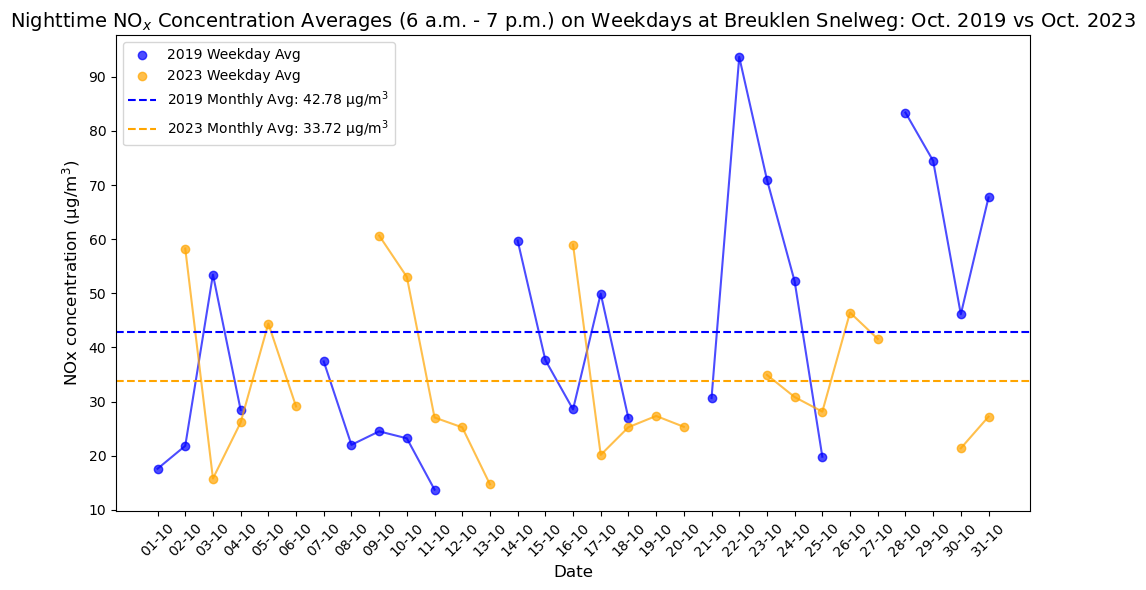

In [22]:
# Compare with weekdays and weekends (night period)

# Filter rows for weekdays in 2019 (Monday to Friday)
night_data_weekdays_2019 = night_data[night_data['begindatumtijd_2019'].dt.weekday < 5]

# Filter rows for weekdays in 2023 (Monday to Friday)
night_data_weekdays_2023 = night_data[night_data['begindatumtijd_2023'].dt.weekday < 5]

# Group by date and calculate daily averages for weekdays in 2019
daily_avg_n_weekdays_2019 = night_data_weekdays_2019.groupby('date').agg(
    avg_NOx_2019=('NL10240_NOx_lucht_2019', 'mean')
).reset_index()

# Group by date and calculate daily averages for weekdays in 2023
daily_avg_n_weekdays_2023 = night_data_weekdays_2023.groupby('date').agg(
    avg_NOx_2023=('NL10240_NOx_lucht_2023', 'mean')
).reset_index()

# Merge both dataframes using an outer join to preserve all dates
daily_avg_n_weekdays = pd.merge(daily_avg_n_weekdays_2019, daily_avg_n_weekdays_2023, on='date', how='outer')

# Format the date column to exclude the year and display as dd-mm
daily_avg_n_weekdays['date'] = daily_avg_n_weekdays['date'].apply(lambda x: x.strftime('%d-%m'))

# Calculate monthly averages for weekdays
monthly_avg_n_2019_weekdays = daily_avg_n_weekdays['avg_NOx_2019'].mean()
monthly_avg_n_2023_weekdays = daily_avg_n_weekdays['avg_NOx_2023'].mean()

# Create the scatter plot for weekdays
plt.figure(figsize=(10, 6))
plt.scatter(daily_avg_n_weekdays['date'], daily_avg_n_weekdays['avg_NOx_2019'], color='blue', label='2019 Weekday Avg', alpha=0.7)
plt.scatter(daily_avg_n_weekdays['date'], daily_avg_n_weekdays['avg_NOx_2023'], color='orange', label='2023 Weekday Avg', alpha=0.7)

# Connect the dots with solid lines for 2019 and 2023
plt.plot(daily_avg_n_weekdays['date'], daily_avg_n_weekdays['avg_NOx_2019'], color='blue', linestyle='-', alpha=0.7)
plt.plot(daily_avg_n_weekdays['date'], daily_avg_n_weekdays['avg_NOx_2023'], color='orange', linestyle='-', alpha=0.7)

# Add horizontal lines for monthly averages
plt.axhline(y=monthly_avg_n_2019_weekdays, color='blue', linestyle='--', linewidth=1.5, label=f'2019 Monthly Avg: {monthly_avg_n_2019_weekdays:.2f} µg/m$^3$')
plt.axhline(y=monthly_avg_n_2023_weekdays, color='orange', linestyle='--', linewidth=1.5, label=f'2023 Monthly Avg: {monthly_avg_n_2023_weekdays:.2f} µg/m$^3$')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel(r'NOx concentration (µg/m$^3$)', fontsize=12)
plt.title('Nighttime NO$_x$ Concentration Averages (6 a.m. - 7 p.m.) on Weekdays at Breuklen Snelweg: Oct. 2019 vs Oct. 2023', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

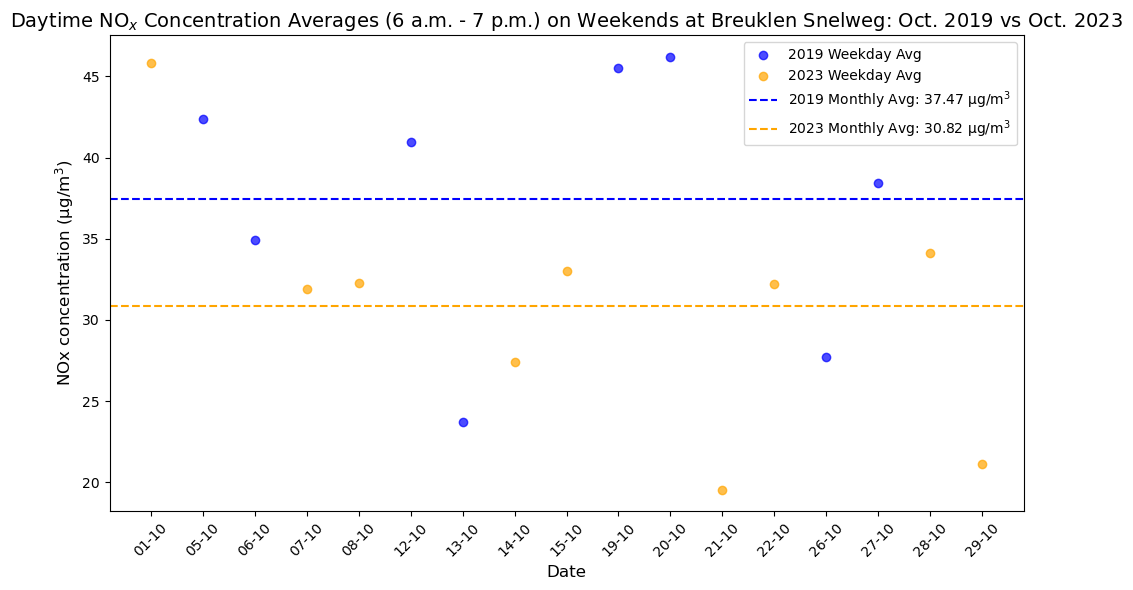

In [24]:
# Compare with weekdays and weekends (night period)

# Filter rows for weekends in 2019 (Saturday to Sunday)
day_data_weekends_2019 = day_data[day_data['begindatumtijd_2019'].dt.weekday >= 5]

# Filter rows for weekends in 2023 (Saturday to Sunday)
day_data_weekends_2023 = day_data[day_data['begindatumtijd_2023'].dt.weekday >= 5]

# Group by date and calculate daily averages for weekends in 2019
daily_avg_d_weekends_2019 = day_data_weekends_2019.groupby('date').agg(
    avg_NOx_2019=('NL10240_NOx_lucht_2019', 'mean')
).reset_index()

# Group by date and calculate daily averages for weekends in 2023
daily_avg_d_weekends_2023 = day_data_weekends_2023.groupby('date').agg(
    avg_NOx_2023=('NL10240_NOx_lucht_2023', 'mean')
).reset_index()

# Merge both dataframes using an outer join to preserve all dates
daily_avg_d_weekends = pd.merge(daily_avg_d_weekends_2019, daily_avg_d_weekends_2023, on='date', how='outer')

# Format the date column to exclude the year and display as dd-mm
daily_avg_d_weekends['date'] = daily_avg_d_weekends['date'].apply(lambda x: x.strftime('%d-%m'))

# Calculate monthly averages for weekends
monthly_avg_d_2019_weekends = daily_avg_d_weekends['avg_NOx_2019'].mean()
monthly_avg_d_2023_weekends = daily_avg_d_weekends['avg_NOx_2023'].mean()

# Create the scatter plot for weekends
plt.figure(figsize=(10, 6))
plt.scatter(daily_avg_d_weekends['date'], daily_avg_d_weekends['avg_NOx_2019'], color='blue', label='2019 Weekday Avg', alpha=0.7)
plt.scatter(daily_avg_d_weekends['date'], daily_avg_d_weekends['avg_NOx_2023'], color='orange', label='2023 Weekday Avg', alpha=0.7)

# Add horizontal lines for monthly averages
plt.axhline(y=monthly_avg_d_2019_weekends, color='blue', linestyle='--', linewidth=1.5, label=f'2019 Monthly Avg: {monthly_avg_d_2019_weekends:.2f} µg/m$^3$')
plt.axhline(y=monthly_avg_d_2023_weekends, color='orange', linestyle='--', linewidth=1.5, label=f'2023 Monthly Avg: {monthly_avg_d_2023_weekends:.2f} µg/m$^3$')

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel(r'NOx concentration (µg/m$^3$)', fontsize=12)
plt.title('Daytime NO$_x$ Concentration Averages (6 a.m. - 7 p.m.) on Weekends at Breuklen Snelweg: Oct. 2019 vs Oct. 2023', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()